# Probability of an outage: Understanding Kenya's Power Grid Reliability Through Data

## Abstract

"When the well is dry, we know the worth of the water." The same is true for electricity: it often takes a blackout to remind us of its value.

Kenya’s electricity sector has made remarkable progress in renewable energy generation, approximately 81% of the electrical energy used comes from clean sources such as geothermal, hydro and wind, 8% of the electrical energy comes from fossil fuel based generation for maintaining voltage stability during peak demand and 11% from imports mainly from Ethiopia (most likely from the Grand Renaissance Hydro Power Dam). Having climate friendly, renewable energy generation has its downsides. Between March and December 2023, Kenya experienced three nationwide blackouts on March 4th, August 25th and December 10th-11th caused by system disturbances , transmission failure and the sudden loss of generation from the Lake Turkana Wind Power Plant. In 2024, nationwide and near-nationwide blackouts were recorded on May 2nd, September 6th and December 18th showing the fragility of the grid’s transmission and balancing capacity. No such blackouts have been recorded in 2025 (as of August) suggesting signs of an improvement in operational control and thus grid resilience.

Utilizing data from the Energy and Petroleum Regulatory Authority (EPRA) reliability indices, Kenya Power (KPLC) public interruption notices collected from October 2023 to Sept 2025, this project estimates the overall probability of a blackout at 0.14. The finding was independently confirmed from System Average Interruption Frequency Index (SAIFI) reliability index and interruption data (0.143). The closeness of the alignment strengthens confidence in the assessment done. The convergence of these two probabilities suggests that KPLC has adopted a more proactive approach to system reliability by strategically scheduling maintenance interruptions to preempt unplanned failures. This may mark a shift toward anticipatory grid management, where “useful” planned outages replace “useless” unplanned interruptions that offer no preventative benefit. 

Overall, the project found that the number of electricity consumers rose by 61% from 6.07m in 2019 to 9.85m in 2025, as Kenya targets 100% renewable energy by 2030. Planned interruptions have become more frequent but also more purposeful, with households averaging four planned outages a month, typically lasting 2.5 hours. Counties such as Nairobi, Nyeri, Kiambu and Kilifi experience higher scheduled outage density due to maintenance prioritization, accounting for 10%, 7%, 6% and 5% of planned interruptions respectively. These counties had either high electrification rates or high populations near a critical urban area. For the use of renewable electricity sources to continue to increase, power reliability must improve rather than decline.


## Description of Access Work - Data Acquisition

In the access section, I located the sources of my would be datasets.

1. [Kenya 2019 Household type of Lighting Fuel (%) Census Data pages 338-349](https://www.knbs.or.ke/wp-content/uploads/2023/09/2019-Kenya-population-and-Housing-Census-Volume-4-Distribution-of-Population-by-Socio-Economic-Characteristics.pdf)

The Kenya National Bureau of Statistics does have a [data portal](http://data.knbs.or.ke/pages/themes) for some of the census data excluding type of Lighting Fuel, also one can request data from them through the email `datarequest@knbs.or.ke`. The email request may have been a simpler method that I did not follow. Instead I took the pdf and snipped it from pages 338 to 349. Then converted that data to excel using the site `https://www.ilovepdf.com/pdf_to_excel`. Their pdf to excel functionality was quite helpful. 


### Summary of access work

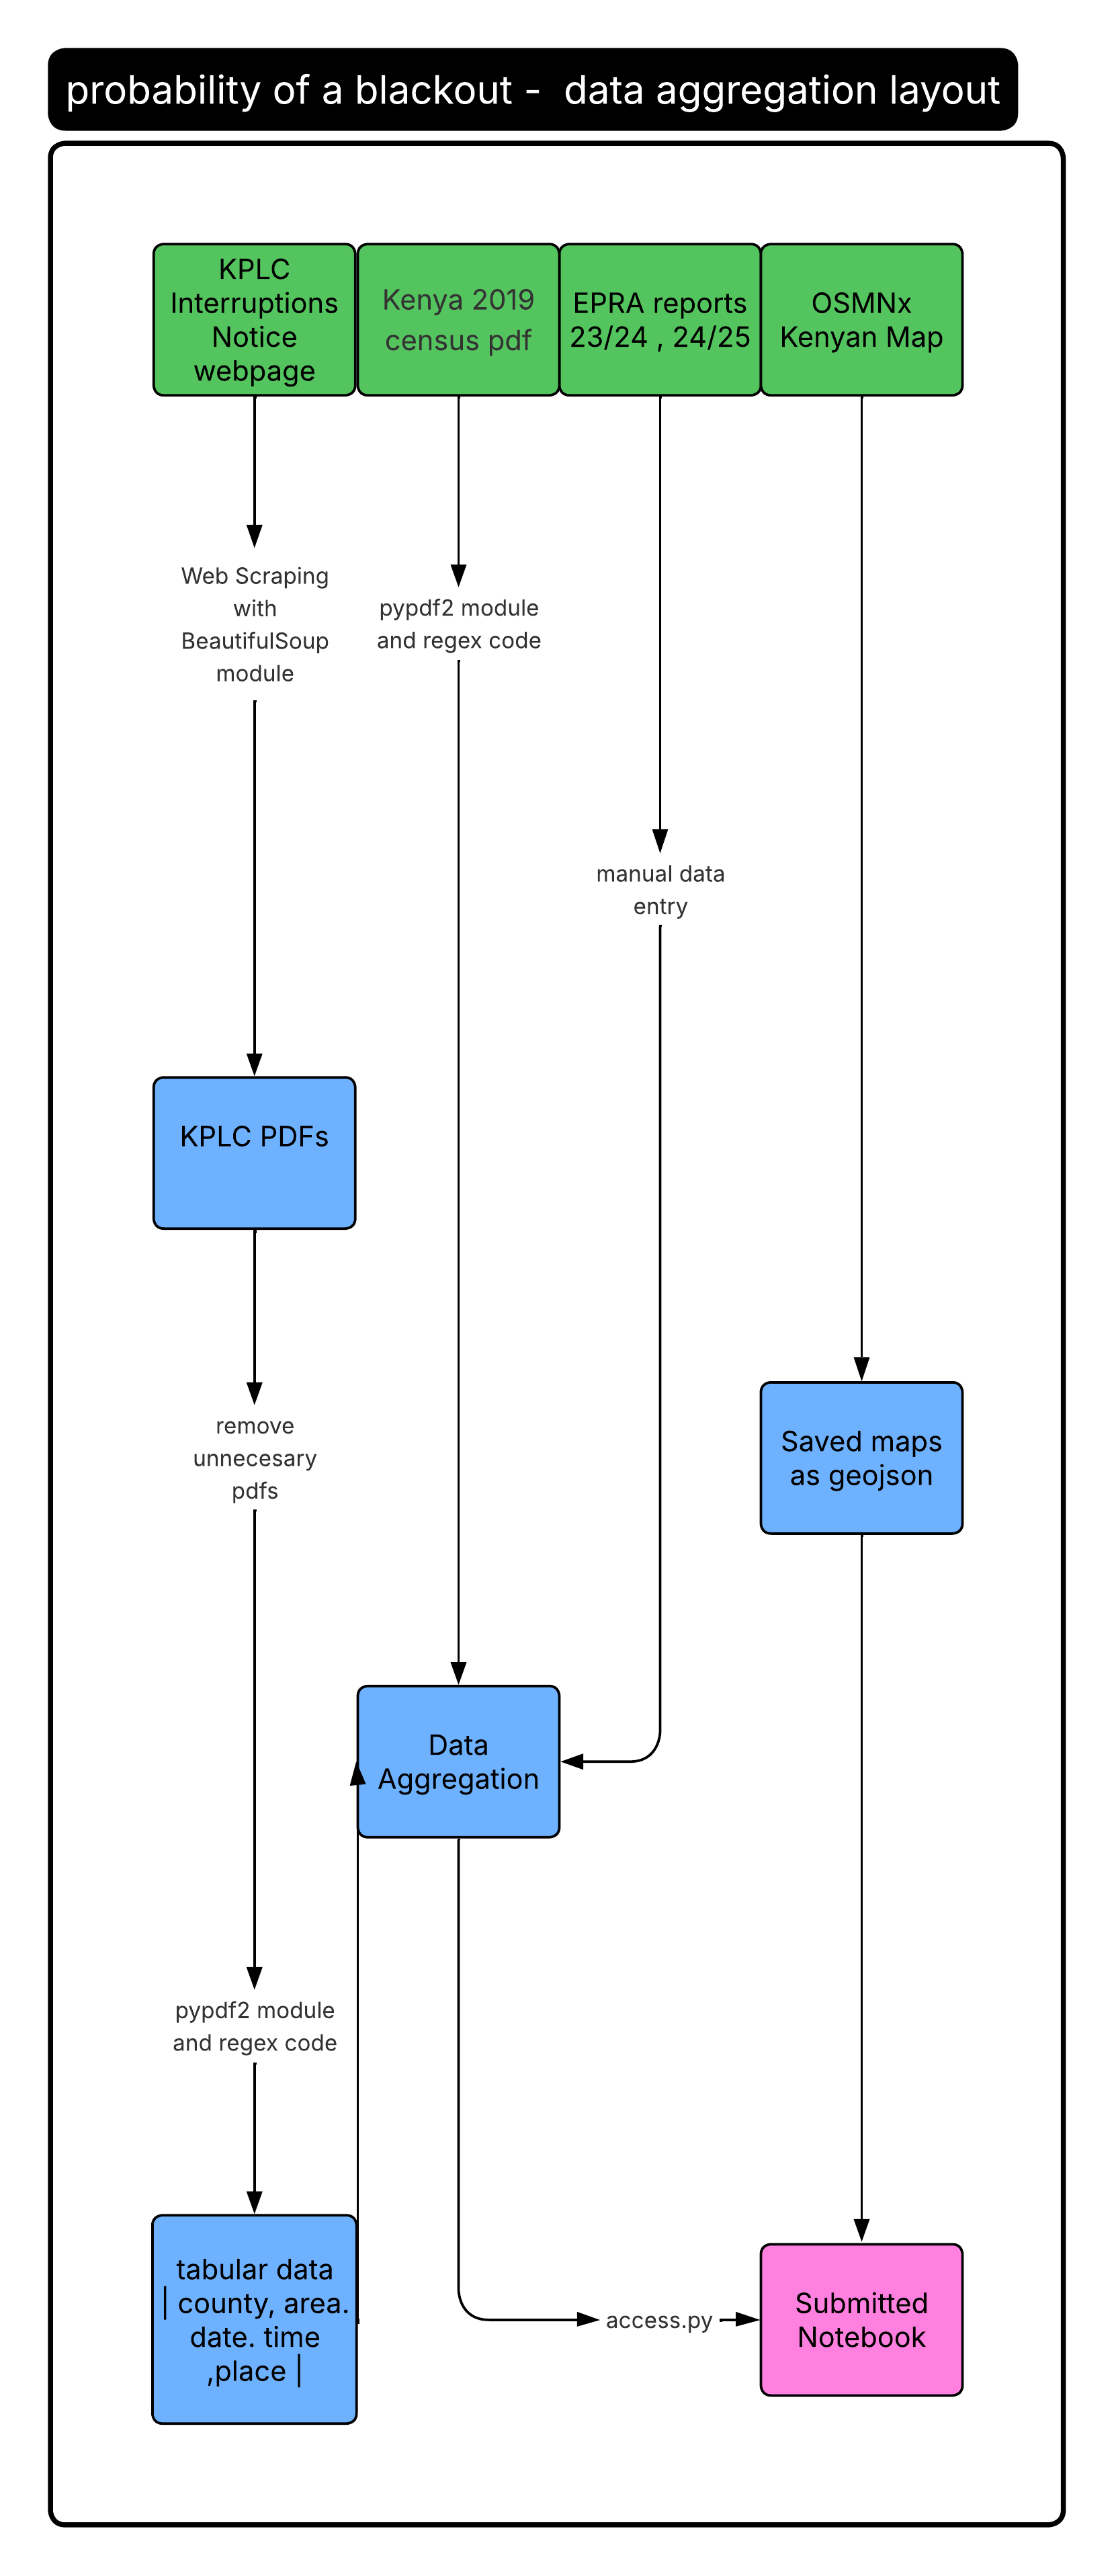
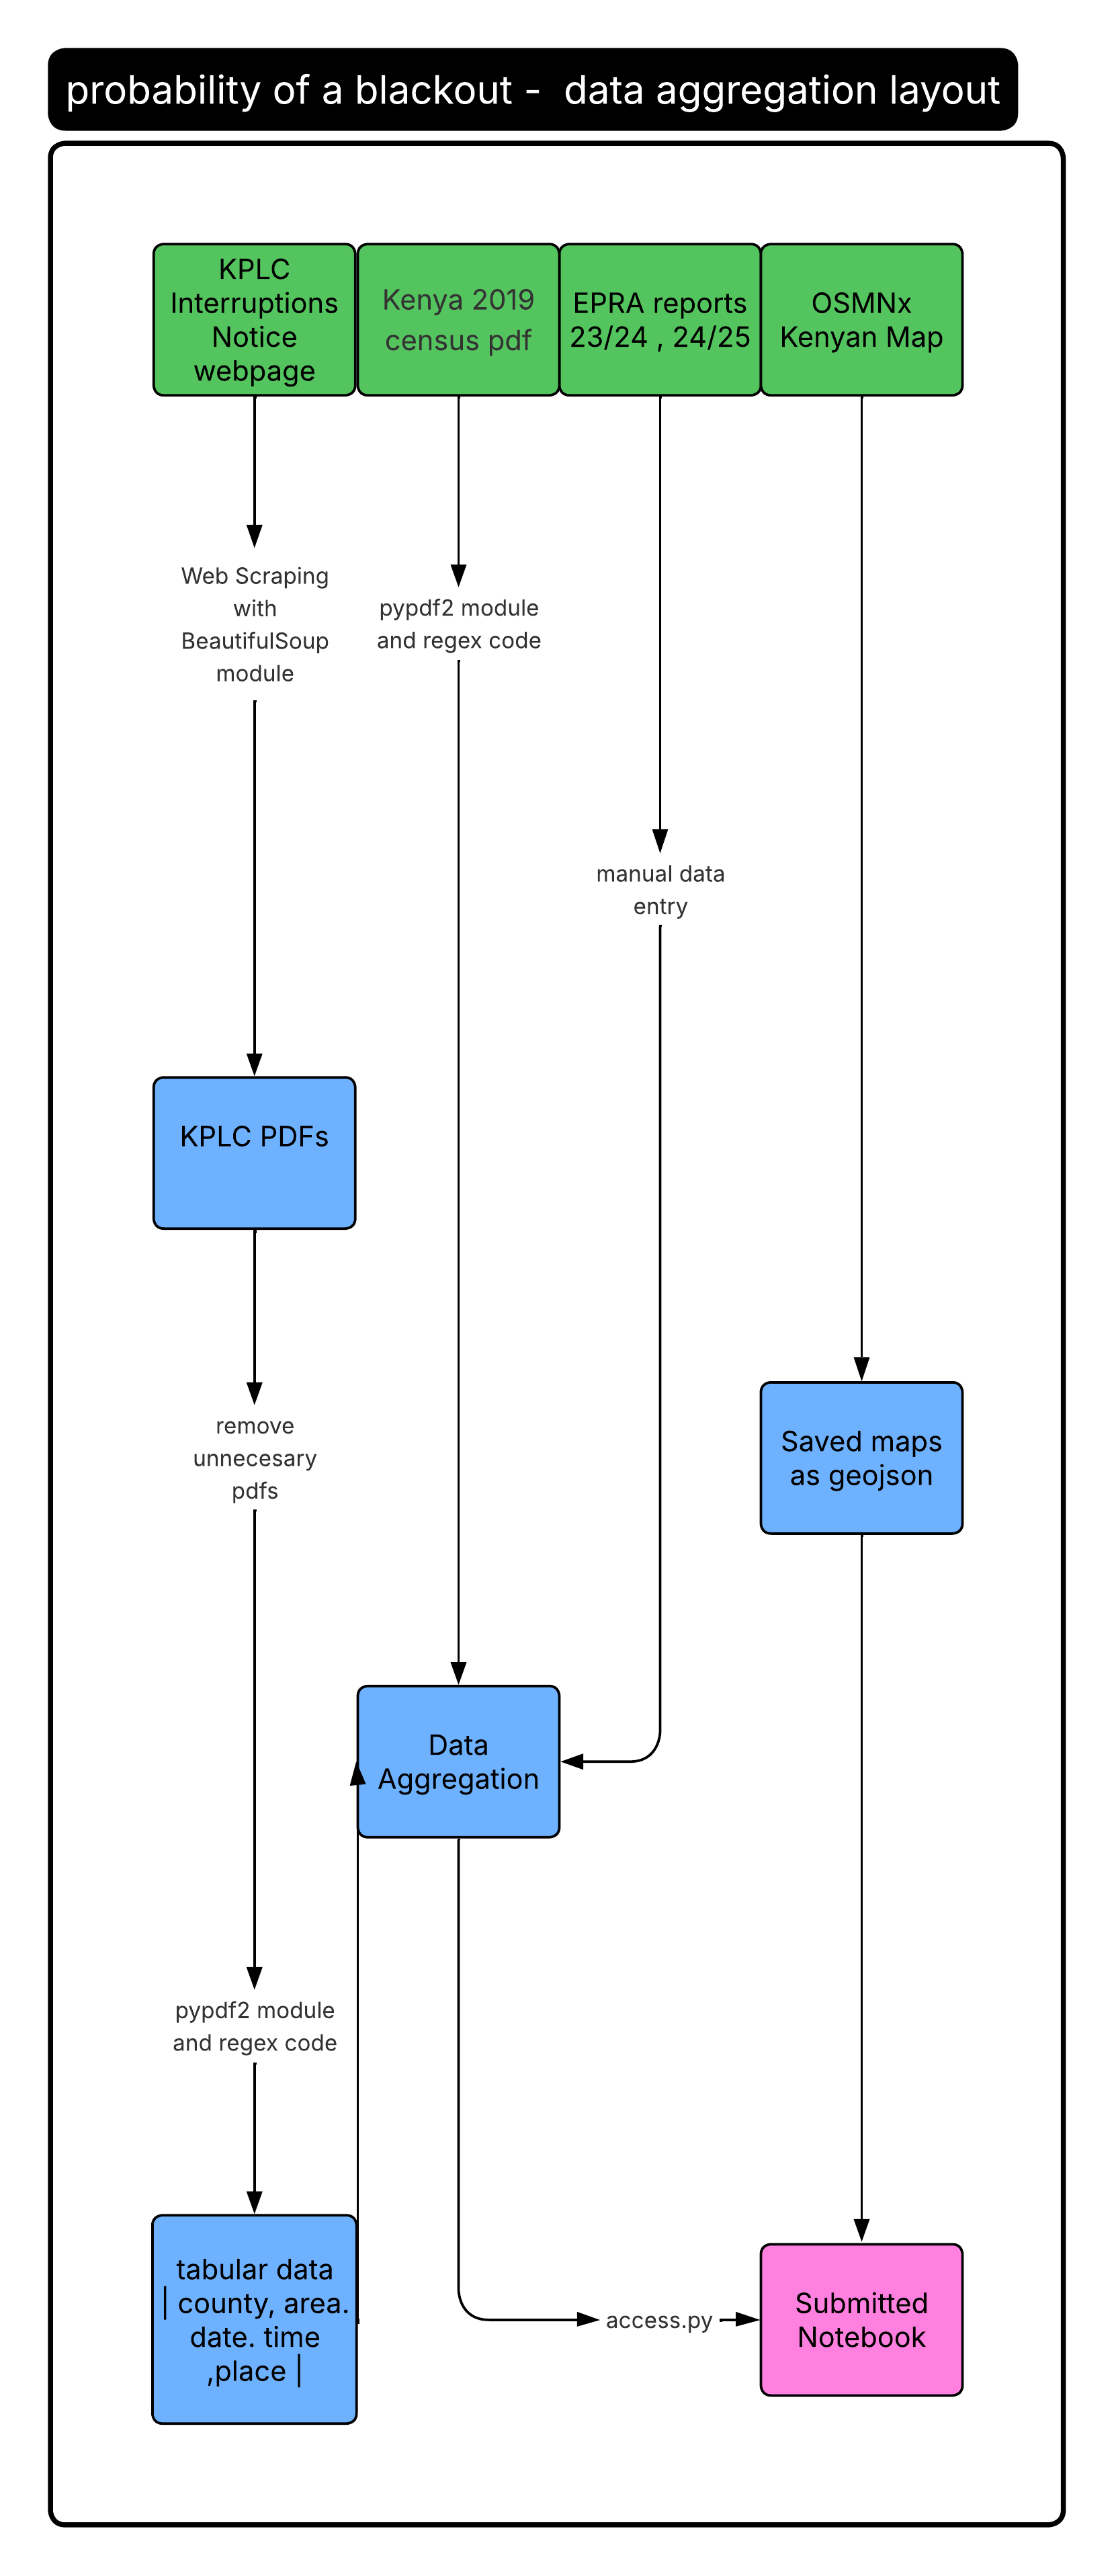

In [ ]:
!git clone https://github.com/Yuri-Njathi/impact-of-planned-vs-unplanned-power-interruptions

In [ ]:
import sys
sys.path.append("impact-of-planned-vs-unplanned-power-interruptions")

In [ ]:
!pip install osmnx
import fynesse

In [ ]:
# Import the Fynesse framework
import fynesse
from fynesse import access, assess, address

# Import common data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Fynesse framework imported successfully")
print(f"📦 Framework version: {fynesse.__version__ if hasattr(fynesse, '__version__') else 'Development'}")

---

## Phase 1: Access - Data Acquisition

The first phase involves gaining access to your data, including handling legal, ethical, and availability challenges.


The data used in this study was obtained from 3 sources:
1.  Number of electrified households from Kenya census data.
2.  Dataset on planned outages in Kenya per county, from KPLC website as pdfs, then extracted the text using `regex` and `pypdf2`. The period covered is 27th October 2023 to 27th September 2025.
3.  Data on Kenyan grid reliability indices from EPRA annual reports with SAIDI, SAIFI and CAIDI data from July 2023 - Dec 2024

This study time overlap is November 2023 to December 2024 but the planned outage data can also answer questions on it's own.

Here I try and answer a few of these questions

In [ ]:
# Load data using the access module
print("🔍 Loading data from access module...")
data = access.epra_data()

if data is not None:
    print(f"✅ Data loaded successfully: {len(data)} rows, {len(data.columns)} columns")
    print(f"📊 Data types: {data.dtypes.value_counts().to_dict()}")
else:
    print("❌ No data available. Please check your data source configuration.")
    print("💡 Tip: Update fynesse/defaults.yml with your data source information")

In [ ]:
epra_data, kplc_data = access.epra_data(), access.census_kplc_data()

In [ ]:
average_people_electrified_per_county = kplc_data['electrified_households'].mean()

## 1. How many Kenyan households are connected to electricity?

In [ ]:
NT = kplc_data.groupby("CODE")["electrified_households"].mean().reset_index().sum()['electrified_households']
print(NT)

In [ ]:
kplc_data

6,066,173 Kenyan households are connected to electricity

## 2. Which Kenyan counties are most and least connected to electricity?

In [ ]:
mean_electricity = kplc_data.groupby("CODE")["Mains Electricity"].mean().reset_index()
county_to_code, code_to_county = access.get_code_county_maps()
mean_electricity["CODE"] = mean_electricity["CODE"].apply(lambda x: str(x).zfill(3))
mean_electricity['County'] = mean_electricity["CODE"].map(code_to_county).str.capitalize()
assess.plot_series(s=mean_electricity.sort_values(by="Mains Electricity", ascending=False)[:10],x="County",y="Mains Electricity",title="Top 10 counties by connection to Electricity",ylabel="Average Electrified Households",xlabel="County")

In [ ]:
assess.plot_series(s=mean_electricity.sort_values(by="Mains Electricity", ascending=True)[:10],x="County",y="Mains Electricity",title="Bottom 10 counties by connection to Electricity",ylabel="Average Electrified Households",xlabel="County")

In [ ]:
#Kenyan Map
gdf_counties, gdf, kenya_poly = assess.get_kenyan_maps()
assess.get_kenyan_map_with_electricity(gdf_counties, gdf, kenya_poly)

### Seems like the southern hemisphere is better electrified (global south) :D

## 3. How many times does the average Kenyan household lose power per month?

In [ ]:
epra_data['SAIFI'].mean(),epra_data['SAIFI'].max(),epra_data['SAIFI'].min()

### 4 times a month (average) , once a week

## 4. When lights go off, how long does it usually last?

In [ ]:
epra_data['CAIDI'].mean(),epra_data['CAIDI'].max(),epra_data['CAIDI'].min()

## 2 and a half hours

## 5. How many hours in a month a Kenyan household without power?

In [ ]:
epra_data['SAIDI'].mean(),epra_data['SAIDI'].max(),epra_data['SAIDI'].min()

## about 10 hours

---

## Phase 2: Assess - Data Quality Assessment

The second phase involves understanding data quality and characteristics without preconceived questions.

In [ ]:
# Assess data quality using the assess module
print("🔍 Assessing data quality...")
assessed_data = assess.census_kplc_data()

if assessed_data is not None:
    print(f"✅ Data assessment completed: {len(assessed_data)} rows, {len(assessed_data.columns)} columns")
    
    # Display basic data quality metrics
    print("\n📈 Data Quality Summary:")
    print(f"   • Missing values: {assessed_data.isnull().sum().sum()} total")
    print(f"   • Duplicate rows: {assessed_data.duplicated().sum()}")
    print(f"   • Memory usage: {assessed_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
else:
    print("❌ Data assessment failed. Check the assess module implementation.")

### Data Quality Visualization

In [ ]:
# Visualize data quality issues
if assessed_data is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Missing values heatmap
    missing_data = assessed_data.isnull()
    if missing_data.any().any():
        sns.heatmap(missing_data, cbar=True, ax=axes[0,0])
        axes[0,0].set_title('Missing Values Heatmap')
    else:
        axes[0,0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('Missing Values Heatmap')
    
    # Data types distribution
    data_types = assessed_data.dtypes.value_counts()
    axes[0,1].pie(data_types.values, labels=data_types.index, autopct='%1.1f%%')
    axes[0,1].set_title('Data Types Distribution')
    
    # Column-wise missing values
    missing_counts = assessed_data.isnull().sum()
    if missing_counts.sum() > 0:
        missing_counts[missing_counts > 0].plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Missing Values by Column')
        axes[1,0].tick_params(axis='x', rotation=45)
    else:
        axes[1,0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Missing Values by Column')
    
    # Numeric data distribution (if available)
    numeric_cols = assessed_data.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        assessed_data[numeric_cols[:3]].hist(ax=axes[1,1], bins=20)
        axes[1,1].set_title('Numeric Data Distribution')
    else:
        axes[1,1].text(0.5, 0.5, 'No Numeric Columns', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Numeric Data Distribution')
    
    plt.tight_layout()
    plt.show()

## 6. As per Q3, you'll experience about 4 interruptions per month, how many of these are planned interruptions?

In [ ]:
kplc_data

In [ ]:
interruptions_per_month = kplc_data.groupby("month_year")["num_instances"].sum().reset_index()
#kenyan_avg = interruptions_per_county["num_instances"].mean()
kenyan_avg = interruptions_per_month["num_instances"]/NT*average_people_electrified_per_county
# print(interruptions_per_month)#kenyan_avg)
kenyan_avg.mean()

In [ ]:
interruptions_per_county = kplc_data.groupby("county")["num_instances"].mean().reset_index()
interruptions_per_county["county"] = interruptions_per_county["county"].str.capitalize()

### As per the data each of the 3.14 interruptions would be caused by planned interruptions on average

## 7. Which counties experience more vs less planned interruptions?

In [ ]:
assess.plot_series(s=interruptions_per_county.sort_values(by="num_instances", ascending=True)[:15],x="county",y="num_instances",title="Counties that experience the least planned interruptions",ylabel="# of interruptions",xlabel="County")

In [ ]:
assess.plot_series(s=interruptions_per_county.sort_values(by="num_instances", ascending=not True)[:15],x="county",y="num_instances",title="Counties that experience the most planned interruptions",ylabel="# of interruptions",xlabel="County")

In [ ]:
s_norm = interruptions_per_county.sort_values(by="num_instances", ascending=not True)
s_norm["percent"] = s_norm["num_instances"] / s_norm["num_instances"].sum()
assess.plot_series(s=s_norm[:8],x="county",y="percent",title="Chance of County to experience planned interruptions",ylabel="chance of interruptions",xlabel="County")

In [ ]:
assess.get_kenyan_map_with_series(df=interruptions_per_county,gdf_counties=gdf_counties, gdf=gdf, kenya_poly=kenya_poly,title="Interruptions per County",col="num_instances")

## 8. Which day of the week has most planned interruptions?

In [ ]:
kplc_only_data = access.kplc_data()
# Count interruptions per day
interruptions_per_day = kplc_only_data["day_of_week"].value_counts(normalize=True).reset_index()
interruptions_per_day.columns = ["day_of_week", "interruptions"]
interruptions_per_day

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=interruptions_per_day, x="day_of_week", y="interruptions", palette="viridis")
plt.title("Interruptions by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Interruptions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
interruptions_per_day = kplc_only_data["day_of_week"].value_counts(normalize=True).reset_index()
interruptions_per_day.columns = ["day_of_week", "interruptions"]
interruptions_per_day

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=interruptions_per_day, x="day_of_week", y="interruptions", palette="viridis")
plt.title("Interruptions by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Interruptions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=interruptions_per_day,
    x="day_of_week",
    y="interruptions",
    palette="viridis"
)

plt.title("Interruptions by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Interruptions")
plt.xticks(rotation=45)

# Annotate values on bars
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}',      # value (no decimals)
        (p.get_x() + p.get_width()/2., p.get_height()), 
        ha='center', va='bottom', 
        fontsize=10, color='black', 
        xytext=(0, 3), textcoords='offset points'
    )

plt.tight_layout()
plt.show()


In [ ]:
# Make sure 'duration_hours' is numeric
kplc_only_data['duration_hours'] = pd.to_numeric(kplc_only_data['duration_hours'], errors='coerce')

# Group by day_of_week and sum the duration
duration_by_day = kplc_only_data.groupby('day_of_week')['duration_hours'].sum().reset_index()

# Optional: sort days in natural order
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
duration_by_day['day_of_week'] = pd.Categorical(duration_by_day['day_of_week'], categories=days_order, ordered=True)
duration_by_day = duration_by_day.sort_values('day_of_week')

print(duration_by_day)

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=duration_by_day, x='day_of_week', y='duration_hours', palette='viridis')
plt.title('Total Planned Interruption Duration by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Duration (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Define the correct weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10,6))
sns.barplot(data=interruptions_per_day,x="day_of_week",y="interruptions",palette="dark:b",order=weekday_order)   # enforce order
plt.title("Interruptions by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Interruptions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Define the correct weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10,6))
sns.barplot(data=interruptions_per_day,x="day_of_week",y="interruptions",palette="RdBu",order=weekday_order)   # enforce order
plt.title("Interruptions by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Interruptions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Define the correct weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10,6))
sns.barplot(data=interruptions_per_day,x="day_of_week",y="interruptions",palette="Paired",order=weekday_order)   # enforce order
plt.title("Interruptions by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Interruptions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Thursdays, Tuesdays and Wednesdays experience most planned interruptions

## Day of the month?

In [ ]:
kplc_only_data['date'] = pd.to_datetime(kplc_only_data['date'], errors='coerce')

# Make sure 'duration_hours' is numeric
kplc_only_data['duration_hours'] = pd.to_numeric(kplc_only_data['duration_hours'], errors='coerce')

# Extract day of month from date column (assuming 'date' exists and is datetime)
kplc_only_data['day_of_month'] = kplc_only_data['date'].dt.day
kplc_only_data['day_of_month'] = kplc_only_data['day_of_month'].apply(lambda x: str(x))
# 1️⃣ Number of interruptions per day
interruptions_per_day = kplc_only_data['day_of_month'].value_counts(ascending=True).reset_index()
interruptions_per_day.columns = ['day_of_month', 'interruptions']
#interruptions_per_day = interruptions_per_day.sort_values('day_of_month')

plt.figure(figsize=(12,6))
sns.barplot(data=interruptions_per_day, x='day_of_month', y='interruptions', palette='viridis')
plt.title("Number of Interruptions by Day of Month")
plt.xlabel("Day of Month")
plt.ylabel("Number of Interruptions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2️⃣ Total duration per day
kplc_only_data['day_of_month'] = kplc_only_data['day_of_month'].apply(lambda x: str(x))
duration_by_day = kplc_only_data.groupby('day_of_month')['duration_hours'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=duration_by_day, x='day_of_month', y='duration_hours', palette='viridis')
plt.title("Total Interruption Duration by Day of Month")
plt.xlabel("Day of Month")
plt.ylabel("Total Duration (hours)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
kplc_only_data['date'] = pd.to_datetime(kplc_only_data['date'], errors='coerce')

# Make sure 'duration_hours' is numeric
kplc_only_data['duration_hours'] = pd.to_numeric(kplc_only_data['duration_hours'], errors='coerce')

# Extract day of month from date column (assuming 'date' exists and is datetime)
kplc_only_data['day_of_month'] = kplc_only_data['date'].dt.day
kplc_only_data['day_of_month'] = kplc_only_data['day_of_month'].apply(lambda x: str(x))
# 1️⃣ Number of interruptions per day
interruptions_per_day = kplc_only_data['day_of_month'].value_counts(ascending=True,normalize=True).reset_index()
interruptions_per_day.columns = ['day_of_month', 'interruptions']
#interruptions_per_day = interruptions_per_day.sort_values('day_of_month')

plt.figure(figsize=(12,6))
sns.barplot(data=interruptions_per_day, x='day_of_month', y='interruptions', palette='viridis')
plt.title("Chance of Interruptions by Day of Month")
plt.xlabel("Day of Month")
plt.ylabel("chance of Interruptions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2️⃣ Total duration per day
kplc_only_data['day_of_month'] = kplc_only_data['day_of_month'].apply(lambda x: str(x))
duration_by_day = kplc_only_data.groupby('day_of_month')['duration_hours'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=duration_by_day, x='day_of_month', y='duration_hours', palette='viridis')
plt.title("Total Interruption Duration by Day of Month")
plt.xlabel("Day of Month")
plt.ylabel("Total Duration (hours)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Analyze data using the address module
print("🔍 Analyzing data to address specific questions...")
analysis_results = address.analyze_data(assessed_data)

if 'error' not in analysis_results:
    print("✅ Data analysis completed successfully")
    print(f"📊 Sample size: {analysis_results.get('sample_size', 'N/A')}")
    print(f"📋 Columns analyzed: {len(analysis_results.get('columns', []))}")
    print(f"🔍 Analysis complete: {analysis_results.get('analysis_complete', False)}")
else:
    print(f"❌ Analysis failed: {analysis_results.get('error', 'Unknown error')}")

In [ ]:
# Display analysis results
if 'error' not in analysis_results and assessed_data is not None:
    # Create summary visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Data overview
    axes[0,0].text(0.1, 0.8, f'Sample Size: {len(assessed_data)}', fontsize=12, transform=axes[0,0].transAxes)
    axes[0,0].text(0.1, 0.6, f'Columns: {len(assessed_data.columns)}', fontsize=12, transform=axes[0,0].transAxes)
    axes[0,0].text(0.1, 0.4, f'Memory: {assessed_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB', fontsize=12, transform=axes[0,0].transAxes)
    axes[0,0].set_title('Data Overview')
    axes[0,0].axis('off')
    
    # Missing values summary
    missing_pct = (assessed_data.isnull().sum() / len(assessed_data)) * 100
    if missing_pct.sum() > 0:
        missing_pct[missing_pct > 0].plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Missing Values (%)')
        axes[0,1].tick_params(axis='x', rotation=45)
    else:
        axes[0,1].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Missing Values (%)')
    
    # Data types
    data_types = assessed_data.dtypes.value_counts()
    axes[1,0].pie(data_types.values, labels=data_types.index, autopct='%1.1f%%')
    axes[1,0].set_title('Data Types')
    
    # Numeric summary (if available)
    numeric_cols = assessed_data.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        assessed_data[numeric_cols[:3]].boxplot(ax=axes[1,1])
        axes[1,1].set_title('Numeric Data Distribution')
        axes[1,1].tick_params(axis='x', rotation=45)
    else:
        axes[1,1].text(0.5, 0.5, 'No Numeric Columns', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Numeric Data Distribution')
    
    plt.tight_layout()
    plt.show()

---

## Phase 3: Address - Question Answering

The third phase involves answering specific questions using the assessed data, including modeling and visualization.

### Analysis Results Visualization

## 9. What is the relationship between the indexes and the planned interruptions

In [ ]:
kplc_data

In [ ]:
interruptions_per_month = kplc_data.groupby("month_year")["num_instances"].sum().reset_index()
print(interruptions_per_month.shape[0])
interruptions_per_month.head()

In [ ]:
duration_of_interruptions_per_month = kplc_data.groupby("month_year")["total_duration"].sum().reset_index()
duration_of_interruptions_per_month.head()

In [ ]:
diipm = interruptions_per_month.merge(duration_of_interruptions_per_month, on="month_year", how="outer")

In [ ]:
counties_merged = diipm.merge(epra_data, left_on="month_year", right_on="month_year_fmt", how="outer")
counties_merged[['num_instances','total_duration','SAIDI','CAIDI','SAIFI']].head()

In [ ]:
counties_merged.head(20)

In [ ]:
counties_merged.describe()

In [ ]:
corr_matrix = counties_merged[['num_instances','total_duration','SAIDI','CAIDI','SAIFI']].corr()

In [ ]:
# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Indices and kplc planned interruptions")
plt.show()


Number of instances and duraion of instances has a +ve correlation of 0.5

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=duration_of_interruptions_per_month, x="month_year", y="total_duration", palette="viridis")
plt.title("Total Planned Interruption Duration by Month")
plt.xlabel("Month-Year")
plt.ylabel("Total Duration (hours)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=interruptions_per_month, x="month_year", y="num_instances", palette="viridis")
plt.title("Total Planned Interruptions by Month")
plt.xlabel("Month-Year")
plt.ylabel("Total Interruptions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

# #counties_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
# counties_merged.dropna(subset=["total_duration", "SAIDI"], inplace=True)
plt.figure(figsize=(10,6))

# Remove grid
sns.set_style("white")  # removes background grid

# Barplot for total duration
ax1 = plt.twinx()
sns.barplot(data=duration_of_interruptions_per_month, x="month_year", y="total_duration", palette="viridis",ax=ax1)

# Create secondary axis for SAIDI
ax2 = plt.twinx()

# Line plot for SAIDI
sns.lineplot(data=counties_merged,x="month_year",y="SAIDI",marker="o",color="red",ax=ax2)


# Create secondary axis for SAIDI
ax3 = plt.twinx()

# Line plot for SAIDI
sns.lineplot(data=counties_merged,x="month_year",y="SAIFI",marker="o",color="orange",ax=ax3)

# Create secondary axis for SAIDI
ax4 = plt.twinx()

# Line plot for SAIDI
sns.lineplot(data=counties_merged,x="month_year",y="CAIDI",marker="o",color="blue",ax=ax4)

# Titles and labels
plt.title("Total Planned Interruption Duration, SAIDI, SAIFI and CAIDI by Month")
#plt.xlabel("Month-Year")
# ax1.set_ylabel("Total Duration (hours)")
# ax2.set_ylabel("SAIDI")
plt.xlabel("")
ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")
ax4.set_ylabel("")
ax1.set_xlabel("Month-Year")
# Legends
plt.legend(loc="upper right")
# ax2.legend(loc="upper right")
# ax3.legend(loc="upper right")
# ax4.legend(loc="upper right")
# Force both axes to share limits
ax2.set_ylim(0, 12)
ax3.set_ylim(0, 12)
ax4.set_ylim(0, 12)


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

plt.figure(figsize=(12,6))
sns.set_style("white")

# Main axis (barplot)
fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(
    data=duration_of_interruptions_per_month,
    x="month_year", y="total_duration",
    palette="viridis", ax=ax1
)
ax1.set_ylabel("Total Duration (hours)", fontsize=12)
ax1.set_xlabel("Month-Year", fontsize=12)

# Secondary axis for SAIDI
ax2 = ax1.twinx()
sns.lineplot(data=counties_merged, x="month_year", y="SAIDI",marker="o", color="red", ax=ax2, label="SAIDI")
ax2.set_ylabel("SAIDI-SAIFI-CAIDI", fontsize=12)
ax2.set_ylim(0, 12)

# Third axis (shift outward for SAIFI)
ax3 = ax1.twinx()
#ax3.spines["right"].set_position(("outward", 50))  # shift right
sns.lineplot(data=counties_merged, x="month_year", y="SAIFI",marker="o", color="orange", ax=ax3, label="SAIFI")
ax3.set_ylabel("", fontsize=12)
ax3.set_ylim(0, 12)

# Fourth axis (shift outward for CAIDI)
ax4 = ax1.twinx()
#ax4.spines["right"].set_position(("outward", 100))  # shift further right
sns.lineplot(data=counties_merged, x="month_year", y="CAIDI",marker="o", color="blue", ax=ax4, label="CAIDI")
ax4.set_ylabel("", fontsize=12)
ax4.set_ylim(0, 12)

# Title
ax1.set_title("Total Planned Interruption Duration, SAIDI, SAIFI and CAIDI by Month", fontsize=14)

# Rotate x labels
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Combine legends
lines, labels = [], []
for ax in [ax2, ax3, ax4]:
    line, label = ax.get_legend_handles_labels()
    lines += line
    labels += label
ax1.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.show()


---

## Next Steps: Customizing Your Analysis

---

## Framework Benefits

✅ **Structured Approach**: Clear phases for data science projects  
✅ **Modern Python**: Type hints, error handling, logging  
✅ **Professional Quality**: Testing, formatting, linting  
✅ **Educational**: Clear implementation guides and examples  
✅ **Extensible**: Easy to customize for your specific needs  
✅ **Reproducible**: Poetry ensures consistent environments  

This template provides a solid foundation for professional data science projects while remaining accessible for learning and teaching.